# Init

In [2]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing as pp, visualization
import modules.data_generation as data_generation
from modules.data_generation import DataGenerator
from modules import filtering, data_projection as dp
import matplotlib.pyplot as plt

logger = logging.getLogger("dataGenNb")


## Generate data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [33]:
dg = DataGenerator(natoms=100, nclusters=7, natoms_per_cluster=[1, 1, 1, 1, 1, 1, 1], nframes_per_cluster=1000, 
                   noise_level=0.01, #1e-2, #1e-2, 
                   displacement=0.1, 
                   noise_natoms=None,
                   feature_type='carteesian_rot', #carteesian_rot_trans
                   test_model='linear') 
#dg.generate_frames()
#dg.generate_clusters()
dg.select_atoms_to_move()
data, labels = dg.generate_frames()
cluster_indices = labels.argmax(axis=1)
feature_to_resids = dg.feature_to_resids()
logger.info("Generated data of shape %s and %s clusters", data.shape, labels.shape[1])

2019-01-21 13:58:03 dataGen-INFO: Selecting atoms to be moved ...
2019-01-21 13:58:03 dataGen-INFO: Generating frames ...
2019-01-21 13:58:07 dataGenNb-INFO: Generated data of shape (7000, 300) and 7 clusters


## Sneak peek the clusters

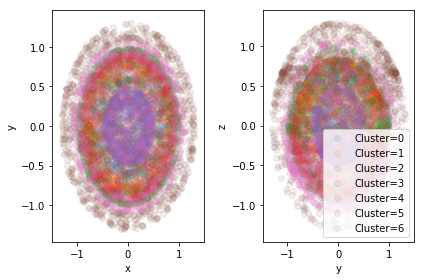

In [34]:
#Only for feature_type == 'cartesian'
gix, [xy_ax, yz_ax] = plt.subplots(1,2)
for ni in range(dg.nclusters):
    xy_ax.scatter(data[ni::dg.nclusters,3*dg.moved_atoms[ni][0]], 
                data[ni::dg.nclusters,3*dg.moved_atoms[ni][0]+1], 
                label="Cluster=%s"%ni, alpha=0.1)    
    yz_ax.scatter(data[ni::dg.nclusters,3*dg.moved_atoms[ni][0] + 1], 
                data[ni::dg.nclusters,3*dg.moved_atoms[ni][0]+ 2], 
                label="Cluster=%s"%ni, alpha=0.1)

plt.legend()
xy_ax.set_xlabel("x")
xy_ax.set_ylabel("y")
yz_ax.set_xlabel("y")
yz_ax.set_ylabel("z")
plt.tight_layout()
plt.show()

## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [35]:
n_iterations, n_splits = 1,1 
filter_by_distance_cutoff = False 
feature_extractors = [
    fe.MlpFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, hidden_layer_sizes=(30, 15, 5), training_max_iter=10000, 
                           activation="relu", 
                          filter_by_distance_cutoff=filter_by_distance_cutoff), #, solver="sgd"),
    fe.RbmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, n_components=dg.nclusters, 
                           filter_by_distance_cutoff=filter_by_distance_cutoff),
    fe.ElmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
                           activation="relu",
                           n_nodes=3*dg.nfeatures, 
                           alpha=1.,
                           filter_by_distance_cutoff=filter_by_distance_cutoff),
    fe.KLFeatureExtractor(data, cluster_indices, n_splits=n_splits, 
                           filter_by_distance_cutoff=filter_by_distance_cutoff),
    fe.PCAFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_components=None,
                               filter_by_distance_cutoff=filter_by_distance_cutoff),
    fe.RandomForestFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
                                                               filter_by_distance_cutoff=filter_by_distance_cutoff),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2019-01-21 13:58:24 mlp-DEBUG: Initializing MLP with the following parameters:                       n_splits 1, n_iterations 1, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       hidden_layer_sizes (30, 15, 5), solver lbfgs, activation function relu, randomize True, training_max_iter 10000
2019-01-21 13:58:24 rbm-DEBUG: Initializing RBM with the following parameters:                       n_splits 1, n_iterations 1, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       n_components 8, randomize True, method from_lrp
2019-01-21 13:58:24 mlp-DEBUG: Initializing MLP with the following parameters:                       n_splits 1, n_iterations 1, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       hidden_layer_sizes (100,), solver lbfgs, activation function relu, randomize True, training_max_iter 100000
2019-01-21 13:58:24 elm-DEBUG: Initializing ELM with the following parameters:

In [36]:
results = []
for extractor in feature_extractors:
    extractor.error_limit = 500
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2019-01-21 13:58:26 dataGenNb-INFO: Computing relevance for extractors MLP
2019-01-21 13:58:26 Extracting features-INFO: Performing feature extraction with MLP on data of shape (7000, 300)
2019-01-21 13:58:26 Extracting features-INFO: Using all data in training and validation sets
2019-01-21 13:58:26 mlp-DEBUG: Training MLP with 7000 samples and 300 features ...
2019-01-21 14:01:32 mlp-DEBUG: Extracting feature importance using MLP ...
2019-01-21 14:01:32 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame between min and max ...
2019-01-21 14:01:32 Extracting features-INFO: Done with MLP
2019-01-21 14:01:32 Extracting features-INFO: ------------------------------
2019-01-21 14:01:32 dataGenNb-INFO: Computing relevance for extractors RBM
2019-01-21 14:01:32 Extracting features-INFO: Performing feature extraction with RBM on data of shape (7000, 300)
2019-01-21 14:01:33 Extracting features-INFO: Using all data in training and validation sets
2019-01-21 14:01:33 rbm

# Postprocess results to get average features

In [37]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = pp.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir=None, feature_to_resids=feature_to_resids, 
                                     filter_results=False,
                                     #filter_results_by_cutoff=False,
                                     predefined_relevant_residues=dg.moved_atoms)
    p.average()
    postprocessors.append(p)

logger.info("Done")


2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21

# Evaluate results

## Find top ranked residues

2019-01-21 14:01:38 dataGenNb-INFO: Actual atoms moved: [[15], [32], [35], [51], [52], [57], [84]].
(Cluster generation method linear. Noise level=0.01, displacement=0.1. frames/cluster=1000)
2019-01-21 14:01:38 dataGenNb-INFO: Moved atoms for MLP: [15, 32, 35, 51, 52, 57, 84]
2019-01-21 14:01:38 dataGenNb-INFO: Moved atoms for RBM: [35, 39, 44, 54, 60, 80, 96]
2019-01-21 14:01:38 dataGenNb-INFO: Moved atoms for ELM: [17, 20, 26, 49, 76, 89, 99]
2019-01-21 14:01:38 dataGenNb-INFO: Moved atoms for KL: [15, 20, 32, 35, 36, 84, 93]
2019-01-21 14:01:38 dataGenNb-INFO: Moved atoms for PCA: [6, 10, 24, 55, 56, 58, 92]
2019-01-21 14:01:38 dataGenNb-INFO: Moved atoms for RF: [15, 32, 35, 51, 52, 57, 84]


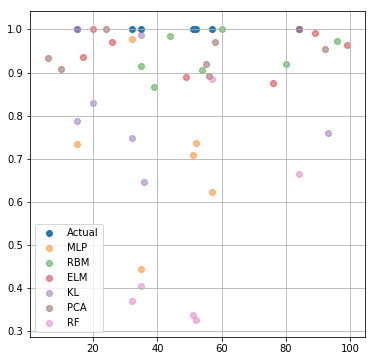

In [38]:
logger.info("Actual atoms moved: %s.\n(Cluster generation method %s. Noise level=%s, displacement=%s. frames/cluster=%s)", 
            sorted(dg.moved_atoms), 
            dg.test_model, dg.noise_level, dg.displacement, dg.nframes_per_cluster)
def show_moved_atoms(dg, postprocessors):
    plt.figure(figsize=(6,6))
    yvalues = np.zeros(len(dg.moved_atoms)) + 1
    plt.scatter(dg.moved_atoms, yvalues, label="Actual")
    for pp in postprocessors:
        #Get most relevant atoms, not that they are not sorted
        label=pp.extractor.name
        moved_atoms = np.argpartition(pp.importance_per_residue, -dg.nclusters)[-dg.nclusters:]
        importance_moved_atoms = pp.importance_per_residue[moved_atoms]
        plt.scatter(moved_atoms, importance_moved_atoms, label=label, alpha=0.5)
        logger.info("Moved atoms for %s: %s", label, sorted(moved_atoms) )
    plt.legend()
    plt.grid()
    plt.show()
    
show_moved_atoms(dg, postprocessors)    

# Remap and persist results 

In [39]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = pp.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     ".", 
                                     pdb_file=None,
                                     feature_to_resids=feature_to_resids, filter_results=True)
    p.average()
    p.evaluate_performance()
    p.persist()
    postprocessors.append([p])
logger.info("Done")


2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 filtering-INFO: Filtering feature importances by median ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 utils-INFO: Rescaling feature importances ...
2019-01-21 14:01:38 projection-INFO: Scoring raw projections.
2019-01-21 14:02:02 utils-INFO: Rescaling feature importances ...
2019-01-21 14:02:02 filtering-INFO: Filtering feature importances by median ...
2019-01-21 14:02:02 utils-INFO: Rescaling feature importances ...
2019-01-21 14:02:02 utils-INFO: Rescaling feature importances ...
2019-01-21 14:02:02 projection-INFO: Scoring raw projections.
2019-01-21 14:02:26 utils-INFO: Rescaling feature importances ...
2019-01-21 14:02:26 filtering-INFO: Filtering feature importances by median ...
2019-01-21 14:02:26 utils-INFO: Rescaling feature importances ...
2019-01-21 14:02:26 utils-INFO: Rescaling feature importances ...
2019-01-21 14:02:26 projection-INFO: Scori

# Visualize

2019-01-21 15:13:01 dataGenNb-INFO: Actual atoms moved: [[15], [32], [35], [51], [52], [57], [84]].
(Cluster generation method linear. Noise level=0.01, displacement=0.1. frames/cluster=1000)
2019-01-21 15:13:01 utils-INFO: Rescaling feature importances ...


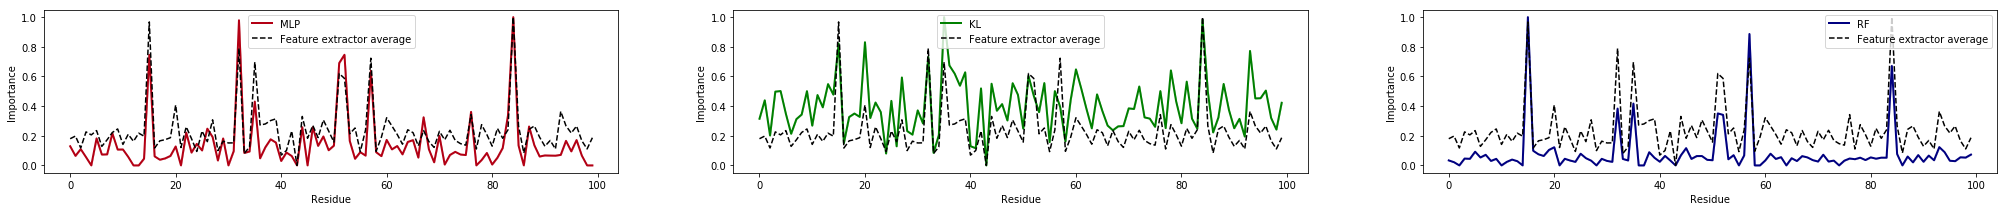

2019-01-21 15:13:01 dataGenNb-INFO: Done. The settings were n_iterations, n_splits = 1, 1.
Filtering (filter_by_distance_cutoff = False)


In [46]:
logger.info("Actual atoms moved: %s.\n(Cluster generation method %s. Noise level=%s, displacement=%s. frames/cluster=%s)", 
            sorted(dg.moved_atoms), 
            dg.test_model, dg.noise_level, dg.displacement, dg.nframes_per_cluster)
visualization.visualize(postprocessors,
          show_importance=True, 
          show_performance=False, 
          show_projected_data=False)

logger.info("Done. The settings were n_iterations, n_splits = %s, %s.\nFiltering (filter_by_distance_cutoff = %s)", 
            n_iterations, n_splits, filter_by_distance_cutoff)